## Functions scripts

In [1]:
def intensity_filter(file,slices,ROI):
    
    #libraries import
    import laspy
    import numpy as np
    import matplotlib.pyplot as plt #removable if make_plots!='y'
    import time #removable
    
    start = time.time() #removable

    #variable type test
    if np.array([type(file)!=str , np.array([type(slices)!=int,type(slices)!=float]).all()]).any() :
        return print("error: wrong type of variable")
    
    #will perform if ROI is set to 'auto'
    def autoROI(file):
        import laspy
        import numpy as np
        path = '1-your_initial_data/' 
        cloud = laspy.read(path+file)
        scale = cloud.header.scales
        x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
        x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
        intensity = cloud.intensity.reshape(len(x),1)
        CLOUD = np.hstack([x,y,z,intensity])
        mean , std = CLOUD[:,:2].mean(axis=0) , CLOUD[:,:2].std(axis=0)
        ROIxmin , ROIymin = mean-2*std 
        ROIxmax , ROIymax = mean+2*std
        return [ROIxmin,ROIxmax,ROIymin,ROIymax]
    
    if type(ROI)!=list:
        if ROI == 'auto':
            ROI = autoROI(file)
        else:
            return print("error: wrong type of variable")
    
    if len(ROI)!=4:
        return print('ROI should be a list of 4 limits: [xmin,xmax,ymin,ymax]. Please try again.')
    
    
    #importing the cloud
    path = '1-your_initial_data/' 
    path1 = path + file
    
    cloud = laspy.read(path1)
    scale = cloud.header.scales
    x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
    x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
    intensity = cloud.intensity.reshape(len(x),1)
    CLOUD = np.hstack([x,y,z,intensity])
    n , n_param = CLOUD.shape
    print('')
    print(file,':',n,'points and',n_param,'parameters found')
    
    #plotting if variable make_plots is active
    if make_plots=='y': 
        def scatter_hist(x, y, ax, ax_histx, ax_histy, c): #source : matplotlib documentation
            ax_histx.tick_params(axis="x", labelbottom=False)
            ax_histy.tick_params(axis="y", labelleft=False)
            ax.scatter(x, y,s=0.05,alpha=0.1,c=c)
            binwidth = 2
            xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
            lim = (int(xymax/binwidth) + 1) * binwidth
            bins = np.arange(-lim, lim + binwidth, binwidth)
            ax_histx.hist(x, bins=bins,color=c)
            ax_histy.hist(y, bins=bins, orientation='horizontal',color=c)

        fig = plt.figure(figsize=(6,6))
        gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)
        ax = fig.add_subplot(gs[1, 0])
        plt.xlabel('x axis')
        plt.ylabel('y axis')
        ax_x = fig.add_subplot(gs[0, 0],sharex=ax)
        ax_y = fig.add_subplot(gs[1, 1],sharey=ax)
        scatter_hist(x, y, ax, ax_x, ax_y,'g')


    #defining the ROI in the (x,y) plan
    ROIxmax = ROI[1]
    ROIxmin = ROI[0]
    ROIymax = ROI[3]
    ROIymin = ROI[2]
    center = (ROIxmax+ROIxmin)/2 , (ROIymax+ROIymin)/2

    if make_plots=='y': 
        ax.scatter([ROIxmin,ROIxmin,ROIxmax,ROIxmax],[ROIymin,ROIymax,ROIymin,ROIymax],marker='+',s=200,c='k')
        plt.show()
    
    #reducing the cloud to ROI dimensions
    CLOUD = CLOUD[CLOUD[:,0]>=ROIxmin]
    CLOUD = CLOUD[CLOUD[:,0]<=ROIxmax]
    CLOUD = CLOUD[CLOUD[:,1]>=ROIymin]
    CLOUD = CLOUD[CLOUD[:,1]<=ROIymax]
    
    #plotting if variable make_plots is active
    if make_plots=='y': 
        plt.subplots(1,2,sharey=True)
        plt.subplot(1,2,1)
        plt.scatter(CLOUD[:,0],CLOUD[:,1],s=0.05,alpha=0.01,c='g')
        plt.xlabel('X axis')
        plt.ylabel('Y axis')
        plt.subplot(1,2,2)
        plt.scatter(CLOUD[:,2],CLOUD[:,1],s=0.05,alpha=0.01,c='g')
        plt.xlabel('Z axis')
        plt.show()
    
    print(np.round(100*len(CLOUD)/n,2),'% of points within the region of interest (ROI)')
    
    #for this slicing we will plot histograms showing the repartition of the points following their intensity
    slices = np.linspace(CLOUD[:,2].min(),CLOUD[:,2].max(),slices+1)
    F_CLOUD = np.zeros((0,4))
    for i in range ( slices ) :
        low , high = slices[i] , slices[i+1]
        slc = CLOUD[CLOUD[:,2]>=low]
        slc = slc[slc[:,2]<high]
        if len(slc)>0:
            initial = len(slc)
            slc = slc[slc[:,3]>=slc[:,3].mean()+2*slc[:,3].std()]
            final = len(slc)
            F_CLOUD = np.vstack([F_CLOUD,slc])
            print('slice',i+1,np.round(100*final/initial,2),'% of points remaining')

    print('Remaining points',len(F_CLOUD),f'({np.round(len(F_CLOUD)*100/n,2)} % of the initial file)')
    
    #plotting if variable make_plots is active
    if make_plots=='y': 
        plt.subplots(2,1,sharex=True,figsize=(5,10))
        plt.subplot(2,1,1)
        plt.title(f'{slices} slices')
        plt.scatter(F_CLOUD[:,0],F_CLOUD[:,2],s=0.1,alpha=0.01,c='g')
        plt.ylabel('Z axis')
        plt.subplot(2,1,2)
        plt.scatter(F_CLOUD[:,0],F_CLOUD[:,1],s=0.05,alpha=0.01,c='g')
        plt.ylabel('Y axis')
        plt.xlabel('X axis')
        plt.show()
    
    #export
    path2 = '2-intensity_filtered_point_cloud/'
    output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
    output_file.X = F_CLOUD[:,0]/scale[0]
    output_file.Y = F_CLOUD[:,1]/scale[1]
    output_file.Z = F_CLOUD[:,2]/scale[2]
    output_file.x = F_CLOUD[:,0]
    output_file.y = F_CLOUD[:,1]
    output_file.z = F_CLOUD[:,2]
    output_file.intensity = F_CLOUD[:,3]
    output_file.write(path2+f"{file[:-4]}_ROI.las")
    
    time = time.time() - start #removable
    
    return print(f'done，processed in {np.round(time,2)} sec')

In [2]:
def DBSCAN_clustering(file,ROIzmin,ROIzmax,eps,min_samples):
    
    #libraries import
    import laspy
    from sklearn.cluster import DBSCAN
    import numpy as np
    import matplotlib.pyplot as plt #removable if make_plots!='y'
    import os , os.path, shutil #removable
    import time #removable
    
    start = time.time() #removable
    
    #path to the classified point cloud of the previous step
    path = '3-trees_point_cloud/trees/'
    path1 = path + file
    #importing the cloud
    cloud = laspy.read(path1)
    scale = cloud.header.scales
    x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
    x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
    intensity = cloud.intensity.reshape(len(x),1)
    CLOUD = np.hstack([x,y,z,intensity]) #our cloud is now a n by 4 matrix (n = number of points)
    
    #DBSCAN will only operate on a thin slice so we save the rest on an other variable
    ROI = CLOUD
    #slice we will focus on
    CLOUD = CLOUD[CLOUD[:,2]<=ROIzmax]
    CLOUD = CLOUD[CLOUD[:,2]>=ROIzmin]
    #ROI parts under and above the slice
    UP_CLOUD = ROI[ROI[:,2]>ROIzmax]
    DOWN_CLOUD = ROI[ROI[:,2]<ROIzmin]
    
    #we compute DBSCAN with the input parameters
    db = DBSCAN(eps=eps,min_samples=min_samples).fit(CLOUD)
    #we get the labels corresponding to clusters IDs
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(n_clusters_,'clusters detected,' , n_noise_,f'points of noise ({np.round(100*n_noise_/len(CLOUD))} %)')

    #saving trunks clusters in a matrix with a fifth column to identify each one
    clusters = np.hstack([CLOUD[labels!=-1],labels[labels!=-1].reshape(len(labels[labels!=-1]),1)])
    
    #getting the centroid of each cluster
    centroids = np.zeros((0,3))
    for cluster in set(clusters[:,4]):
        cl = clusters[clusters[:,4]==cluster][:,:3]
        centroid = cl.mean(axis=0)
        centroids = np.vstack([centroids,centroid])
    
    #plotting if variable make_plots is active
    if make_plots=='y':
        plt.figure(figsize=(7,7))    
        i=0
        for cluster in set(clusters[:,4]):
            i+=1
            points = clusters[clusters[:,4]==cluster][:,:3]
            xmin , xmax = points[:,0].min() , points[:,0].max()
            ymin , ymax = points[:,1].min() , points[:,1].max()
            centroid = centroids[i-1]
            plt.scatter(points[:,0],points[:,1],s=2,alpha=0.5,c='y')
            plt.plot(np.linspace(xmin,xmax,2),
                     np.array([centroid[1],centroid[1]]),
                     c='k',lw=1)
            plt.plot(np.array([centroid[0],centroid[0]]),
                     np.linspace(ymin,ymax,2),
                     c='k',lw=1)
            plt.xlabel('X axis')
            plt.ylabel('Y axis')
        plt.show()
    
    #export
    path_trunk = '4-separated_trees/DBSCAN_trunks/'
    for root, dirs, files in os.walk(path_trunk): #removable
        for f in files:                           #
            os.unlink(os.path.join(root, f))      #
        for d in dirs:                            #
            shutil.rmtree(os.path.join(root, d))  #
    i=0
    for cluster in set(clusters[:,4]):
        i = i+1
        cluster_points = clusters[clusters[:,4]==cluster]
        output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
        output_file.x = cluster_points[:,0]
        output_file.y = cluster_points[:,1]
        output_file.z = cluster_points[:,2]
        output_file.intensity = cluster_points[:,3]
        output_file.write(f"{path_trunk}trunk{i}.las")
        if i<10:
            output_file.write(f"{path_trunk}trunk0{i}.las")
        else:
            output_file.write(f"{path_trunk}trunk{i}.las")
    
    t = time.time() - start
    
    print(f'done，processed in {t} sec')


In [3]:
def merging(dist_to_merge,ROIzmin,ROIzmax):
    
    import laspy
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt #removable if make_plots!='y'
    import os , os.path, shutil #removable but has to be replaced by something else to not break the script
    import time #removable
    
    start = time.time() #removable
    
    #DBSCAN clusters recovering
    path_trunk = '4-separated_trees/DBSCAN_trunks/'
    files = os.listdir(path_trunk)
    files = np.array(files)
    files = files[files!='.DS_Store']
    files_names = []
    for file in files:
        files_names.append(file[:-4])
    clusters = {}
    i = 0
    for file_name in files_names:
        i += 1
        file = files[i-1]
        cloud = laspy.read(path_trunk+file)
        scale = cloud.header.scales
        x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
        x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
        intensity = cloud.intensity.reshape(len(x),1)
        clusters[f'{file_name}'] = np.hstack([x,y,z,intensity])
        centroid = clusters[f'{file_name}'][:,:3].mean(axis=0)
        clusters[f'{file_name}'] = clusters[f'{file_name}'] , centroid
    
    #3D Forest regions acquisition
    path_3df_regions = '4-separated_trees/3DForest_segmented_regions/'
    files = os.listdir(path_3df_regions)
    files = np.array(files)
    files = files[files!='.DS_Store']
    files_names = []
    for file in files:
        files_names.append(file[:-4])
    regions = {}
    i = 0
    for file_name in files_names:
        i += 1
        file = files[i-1]
        regions[f'{file_name}'] = pd.read_csv(path_3df_regions+file,
                                              encoding = "utf-8",
                                              delimiter=' ',
                                              header=None,
                                              names=['x','y','z','intensity'])
        regions[f'{file_name}'] = np.array(regions[f'{file_name}'])
    for file_name in files_names:
        Slice = regions[f'{file_name}'][regions[f'{file_name}'][:,2]<=ROIzmax]
        Slice = Slice[Slice[:,2]>=ROIzmin]
        if len(Slice)>0:
            centroid = Slice[:,:3].mean(axis=0)
        else:
            centroid = np.array([np.nan,np.nan,np.nan])
        regions[f'{file_name}'] = regions[f'{file_name}'] , centroid
    
    #merging
    centroids = []
    reg = []
    j=0
    for i in range (len(regions)):
        key = list(regions.keys())[j]
        centroid = regions[f'{key}'][1]
        if np.isnan(centroid).any():
            del (regions[f'{key}'])
        else:
            centroids.append(centroid)
            reg.append(regions[f'{key}'][0])
            j+=1
    centroids = np.array(centroids)
    centroids = centroids[~np.isnan(centroids).any(axis=1)]
    
    new_regions = []
    count = 0
    control = 'not_ok'
    
    if len(clusters)<=len(regions):
        
        for cluster in clusters.keys():
            centroid = clusters[f'{cluster}'][1]
            dist =  np.linalg.norm(centroids[:,:2]-centroid[:2],axis=1).min()
            while dist<=dist_to_merge:
                count += 1
                control = 'ok'
                idx_min = np.linalg.norm(centroids[:,:2]-centroid[:2],axis=1).argmin()
                new_region = clusters[f'{cluster}'][0]
                new_region = np.vstack([new_region,np.array(reg[idx_min])])
                centroids = np.delete(centroids,idx_min,axis=0)
                del(reg[idx_min])
                dist =  np.linalg.norm(centroids[:,:2]-centroid[:2],axis=1).min()
            if control=='ok':
                if not any(np.array_equal(new_region, reg) for reg in new_regions):
                    new_regions.append(new_region)
    
    else:
        i=0
        centr = []
        regs = []
        for cluster in clusters.keys():
            r = clusters[f'{cluster}'][0]
            centroid = clusters[f'{cluster}'][1]
            centr.append(centroid)
            regs.append(r)
        centr = np.array(centr)
        for region in reg:
            i+=1
            centroid = centroids[i-1]
            dist =  np.linalg.norm(centr[:,:2]-centroid[:2],axis=1).min()
            while dist<=dist_to_merge:
                count += 1
                control = 'ok'
                idx_min = np.linalg.norm(centr[:,:2]-centroid[:2],axis=1).argmin()
                new_region = np.vstack([region,np.array(regs[idx_min])])
                centr = np.delete(centr,idx_min,axis=0)
                del(regs[idx_min])
                dist =  np.linalg.norm(centr[:,:2]-centroid[:2],axis=1).min()
            if control=='ok':
                if not any(np.array_equal(new_region, reg) for reg in new_regions):
                    new_regions.append(new_region)

    print(f'{len(new_regions)} regions detected after co-registration')
    print (count)

    #export
    path_co_reg = '4-separated_trees/Co-registered_regions/'
    for root, dirs, files in os.walk(path_co_reg):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))
    i=0
    for region in new_regions:
        i = i+1
        output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
        output_file.X = region[:,0]/scale[0]
        output_file.Y = region[:,1]/scale[1]
        output_file.Z = region[:,2]/scale[2]
        output_file.x = region[:,0]
        output_file.y = region[:,1]
        output_file.z = region[:,2]
        output_file.intensity = region[:,3]
        if i<10:
            output_file.write(f"{path_co_reg}region0{i}.las")
        else:
            output_file.write(f"{path_co_reg}region{i}.las")
        
    #plotting if variable make_plots is active    
    if make_plots=='y':
        
        plt.figure(figsize=(8,8))

        i=0

        new_centroids = []
        for region in new_regions:
            i += 1
            Slice = region[region[:,2]>=ROIzmin]
            Slice = Slice[Slice[:,2]<=ROIzmax]
            centroid = Slice[:,:3].mean(axis=0)
            if i==1:
                plt.scatter(centroid[0],centroid[1],marker='o',
                            s=100,c='w',edgecolors='r',
                            label='merged regions')
            else:
                plt.scatter(centroid[0],centroid[1],marker='o',
                            s=100,c='w',edgecolors='r')
        i=0

        for cluster in clusters.keys() :
            i += 1
            points = clusters[f'{cluster}'][0]
            xmin = points[:,0].max()
            xmax = points[:,0].min()
            centroid = clusters[f'{cluster}'][1]
            if i==1:
                plt.scatter(centroid[0],centroid[1],c='b',marker='+',label='DBSCAN clusters')
            else:
                plt.scatter(centroid[0],centroid[1],c='b',marker='+')

        i=0

        for region in regions.keys():
            i += 1
            points = regions[f'{region}'][0]
            xmin = points[:,0].max()
            xmax = points[:,0].min()
            centroid = regions[f'{region}'][1]
            if i==1:
                plt.scatter(centroid[0],centroid[1],c='g',marker='x',label='3D Forest segmented regions') 
            else:
                plt.scatter(centroid[0],centroid[1],c='g',marker='x')

        plt.xlabel('X axis')
        plt.ylabel('Y axis')   
        plt.legend(fontsize='xx-small')
        plt.show()
        
        if len(new_regions)<6:
            if len(new_regions)/2 == int(len(new_regions)/2):
                b = int(len(new_regions)/2)
                a = int(len(new_regions)/b)
        else:
            b = 6
            a = int(len(new_regions)/b)
        
        if a*b < len(new_regions):
            a += 1
        
        plt.subplots(a,b,subplot_kw={"projection": "3d"},figsize=(b*3,a*3))
        i=0
        for region in new_regions:
            i+=1
            ax = plt.subplot(a,b,i,projection='3d')
            ax.scatter(region[:,0],region[:,1],region[:,2],s=0.3,c='k',alpha=0.5)
        plt.show()
    
    
    t = time.time() - start #removable
    
    print(f'done，processed in {t} sec')

In [4]:
def region_growing(ROI_file,max_distance_higher_points,max_distance_lower_points,ROIzmin,ROIzmax):
    
    #libraries import
    import laspy
    import numpy as np
    import matplotlib.pyplot as plt #removable if make_plots!='y'
    import os , os.path, shutil #removable but has to be replaced by something else to not break the script
    import time #removable
    
    start = time.time() #removable
    
    path_co_reg = '4-separated_trees/Co-registered_regions/'
    files = os.listdir(path_co_reg)
    files = np.array(files)
    files = files[files!='.DS_Store']
    files_names = []
    for file in files:
        files_names.append(file[:-4])
    
    new_regions = []
    i = 0
    for file_name in files_names:
        i += 1
        file = files[i-1]
        cloud = laspy.read(path_co_reg+file)
        scale = cloud.header.scales
        x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
        x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
        intensity = cloud.intensity.reshape(len(x),1)
        new_regions.append(np.hstack([x,y,z,intensity]))
    
    path = '3-trees_point_cloud/trees/'
    path1 = path + ROI_file  
    cloud = laspy.read(path1)
    scale = cloud.header.scales
    x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
    x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
    intensity = cloud.intensity.reshape(len(x),1)
    CLOUD = np.hstack([x,y,z,intensity])
    ROI = CLOUD
    #slice we will focus on
    CLOUD = CLOUD[CLOUD[:,2]<=ROIzmax]
    CLOUD = CLOUD[CLOUD[:,2]>=ROIzmin]
    #ROI parts under and above the slice
    UP_CLOUD = ROI[ROI[:,2]>ROIzmax]
    DOWN_CLOUD = ROI[ROI[:,2]<ROIzmin]

    print('processing higher parts of the point cloud')
    
    unexplored = UP_CLOUD

    initial = len(unexplored)

    i = 0

    for region in new_regions: #we will process region by region

        init = len(region)

        i += 1

         #initial point to start the growing of each region
        start_point = region[region[:,2].argmax()]
        previous_point = np.zeros((3,1)) #for now we set it as a (0,0,0) array

        #we look for the closest neighbor of the centroid
        neighbor = np.linalg.norm(unexplored[:,:3]-start_point[:3],axis=1).argmin() 
        #note that the first iteration has no condition
        new_regions[i-1] = np.vstack([new_regions[i-1],unexplored[neighbor,:4]])

        #now we prepare to iterate upward by updating the unexplored list, start_point and previous_point
        previous_point = start_point
        start_point = unexplored[neighbor,:3]
        unexplored = np.delete(unexplored,neighbor,axis=0)

        dist=0 #to initialize the next loop

        #now we set the upward iteration, happening while the following condition is respected:
        while dist<max_distance_higher_points:

            #same as in initialization
            neighbor = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).argmin()
            #dist is computed on the new point, if not respecting the condition anymore the iteration will break
            dist = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).min()


            new_regions[i-1] = np.vstack([new_regions[i-1],unexplored[neighbor,:4]])

            #we prepare the next iteration
            previous_point = start_point
            start_point = unexplored[neighbor,:3]
            unexplored = np.delete(unexplored,neighbor,axis=0)


        retrn = -1 #this is the backing step for the backward iteration
        dist = 0 #we reset the dist variable just to permit to initiate the next loop right beneath


        while dist<max_distance_higher_points:

            return_point = new_regions[i-1][retrn,:] #by doing so we go backward on our added points
            previous_point =  new_regions[i-1][retrn-1,:3]

            #same principle as above
            neighbor = np.linalg.norm(unexplored[:,:3]-return_point[:3],axis=1).argmin()

            #we call a new variable that will create upward iteration within this loop
            dist1 = np.linalg.norm(unexplored[:,:3]-return_point[:3],axis=1).min()

            #this reproduces the condition we initially set, and makes the algorithm going backward again
            if dist1>=max_distance_higher_points:
                retrn += - 1
                if abs(retrn-10)>len(new_regions[i-1]): #which means we can't go back up further
                    dist = dist1 #we set this to break the loop because there is necessary dist1>=distance

            #though if the condition is respected, the iteration goes upward for this branch
            else:
                start_point = return_point[:3] #to initialize, since we moved backward and have not updated it

                dist2 = 0 #to initialize the next loop

                #this reproduces the condition we initially set, and makes the algorithm going backward again
                n=0 #we will use this variable to adjust the close region computing the third parameter

                while dist2<max_distance_higher_points:

                    #same principle as above
                    neighbor = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).argmin()

                    #again we call a new variable to makes forward iteration if less than distance threshold
                    dist2 = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).min()

                    new_regions[i-1] = np.vstack([new_regions[i-1],unexplored[neighbor,:4]])
                    #and then we can prepare the next iteration
                    previous_point = start_point
                    start_point = unexplored[neighbor,:3]
                    unexplored = np.delete(unexplored,neighbor,axis=0)

        fin=len(new_regions[i-1])

        print (f'slice {i}/{len(new_regions)}, growed by',np.round(100*fin/init),'%')

    final = len(unexplored)

    print('higher parts of the point cloud',100*final/initial,'% of growth')

    print('processing lower parts of the point cloud')
    
    unexplored = DOWN_CLOUD

    initial = len(unexplored)

    i = 0

    for region in new_regions: #we will process region by region

        init = len(region)

        i += 1

         #initial point to start the growing of each region
        start_point = region[region[:,2].argmax()]
        previous_point = np.zeros((3,1)) #for now we set it as a (0,0,0) array

        #we look for the closest neighbor of the centroid
        neighbor = np.linalg.norm(unexplored[:,:3]-start_point[:3],axis=1).argmin() 
        #note that the first iteration has no condition
        new_regions[i-1] = np.vstack([new_regions[i-1],unexplored[neighbor,:4]])

        #now we prepare to iterate upward by updating the unexplored list, start_point and previous_point
        previous_point = start_point
        start_point = unexplored[neighbor,:3]
        unexplored = np.delete(unexplored,neighbor,axis=0)

        dist=0 #to initialize the next loop

        #now we set the upward iteration, happening while the following condition is respected:
        while dist<max_distance_lower_points:

            #same as in initialization
            neighbor = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).argmin()
            #dist is computed on the new point, if not respecting the condition anymore the iteration will break
            dist = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).min()


            new_regions[i-1] = np.vstack([new_regions[i-1],unexplored[neighbor,:4]])

            #we prepare the next iteration
            previous_point = start_point
            start_point = unexplored[neighbor,:3]
            unexplored = np.delete(unexplored,neighbor,axis=0)


        retrn = -1 #this is the backing step for the backward iteration
        dist = 0 #we reset the dist variable just to permit to initiate the next loop right beneath


        while dist<max_distance_lower_points:

            return_point = new_regions[i-1][retrn,:] #by doing so we go backward on our added points
            previous_point =  new_regions[i-1][retrn-1,:3]

            #same principle as above
            neighbor = np.linalg.norm(unexplored[:,:3]-return_point[:3],axis=1).argmin()

            #we call a new variable that will create upward iteration within this loop
            dist1 = np.linalg.norm(unexplored[:,:3]-return_point[:3],axis=1).min()

            #this reproduces the condition we initially set, and makes the algorithm going backward again
            if dist1>=max_distance_lower_points:
                retrn += - 1
                if abs(retrn-10)>len(new_regions[i-1]): #which means we can't go back up further
                    dist = dist1 #we set this to break the loop because there is necessary dist1>=distance

            #though if the condition is respected, the iteration goes upward for this branch
            else:
                start_point = return_point[:3] #to initialize, since we moved backward and have not updated it

                dist2 = 0 #to initialize the next loop

                #this reproduces the condition we initially set, and makes the algorithm going backward again
                n=0 #we will use this variable to adjust the close region computing the third parameter

                while dist2<max_distance_lower_points:

                    #same principle as above
                    neighbor = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).argmin()

                    #again we call a new variable to makes forward iteration if less than distance threshold
                    dist2 = np.linalg.norm(unexplored[:,:3]-start_point,axis=1).min()

                    new_regions[i-1] = np.vstack([new_regions[i-1],unexplored[neighbor,:4]])
                    #and then we can prepare the next iteration
                    previous_point = start_point
                    start_point = unexplored[neighbor,:3]
                    unexplored = np.delete(unexplored,neighbor,axis=0)

        fin=len(new_regions[i-1])

        print (f'slice {i}/{len(new_regions)}, growed by',np.round(100*fin/init),'%')
        

    final = len(unexplored)

    print('lower parts of the point cloud',100*final/initial,'% of growth')
    
    path_RG = '4-separated_trees/After_region_growing/'

    for root, dirs, files in os.walk(path_RG):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))

    i=0
    for region in new_regions:

        i = i+1
        output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
        output_file.X = region[:,0]/scale[0]
        output_file.Y = region[:,1]/scale[1]
        output_file.Z = region[:,2]/scale[2]
        output_file.x = region[:,0]
        output_file.y = region[:,1]
        output_file.z = region[:,2]
        output_file.intensity = region[:,3]
        if i<10:
            output_file.write(f"{path_RG}reg0{i}.las")
        else:
            output_file.write(f"{path_RG}reg{i}.las")
    
    
    if make_plots=='y':
        
        if len(new_regions)<6:
            if len(new_regions)/2 == int(len(new_regions)/2):
                b = int(len(new_regions)/2)
                a = int(len(new_regions)/b)
        else:
            b = 6
            a = int(len(new_regions)/b)
        
        if a*b < len(new_regions):
            a += 1
    
        plt.subplots(a,b,subplot_kw={"projection": "3d"},figsize=(b*3,a*3))
        i=0
        for region in new_regions:
            i+=1
            ax = plt.subplot(a,b,i,projection='3d')
            ax.scatter(region[:,0],region[:,1],region[:,2],s=0.1,c='k',alpha=0.5)
        plt.show()
    
    
    t = time.time() - start #removable
    
    print(f'done，processed in {t} sec')

In [5]:
def nearest_nbr_reinforcement(original_file, general_threshold, crown_threshold,height_for_crown_threshold,minimum_heigh):
    
    import laspy
    from sklearn.neighbors import NearestNeighbors
    import numpy as np
    import matplotlib.pyplot as plt
    import os , os.path, shutil
    import time
    
    start = time.time()
    
    path_RG = '4-separated_trees/After_region_growing/'
    files = os.listdir(path_RG)
    files = np.array(files)
    files = files[files!='.DS_Store']
    files_names = []
    for file in files:
        files_names.append(file[:-4])
    
    new_regions = []
    i = 0
    for file_name in files_names:
        i += 1
        file = files[i-1]
        cloud = laspy.read(path_RG+file)
        scale = cloud.header.scales
        x , y , z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
        x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
        intensity = cloud.intensity.reshape(len(x),1)
        new_regions.append(np.hstack([x,y,z,intensity]))
    
    path_original_data = '1-your_initial_data/'

    leaves = laspy.read(path_original_data+original_file)

    x , y , z , intensity = leaves.x , leaves.y , leaves.z , leaves.intensity
    x = np.array(leaves.x).reshape((len(x),1))
    y = np.array(leaves.y).reshape((len(x),1))
    z = np.array(leaves.z).reshape((len(x),1))
    intensity = np.array(leaves.intensity).reshape((len(x),1))

    dense_ROI = np.hstack([x , y , z , intensity])
    
    regions = np.zeros((0,5))
    i=0
    for region in new_regions:
        i+=1
        regions = np.vstack([regions,np.hstack([region,i*np.ones((len(region),1))])])
    
    unexplored = np.hstack([dense_ROI,np.zeros((len(dense_ROI),1))])
    merged = np.vstack([unexplored,regions])
    
    knn = NearestNeighbors(n_neighbors=10).fit(merged[:,:3])
    distance_mat, neighbours_mat = knn.kneighbors(merged[:,:3])
    neighbours_mat[distance_mat>=general_threshold] = -9999
    nbr = neighbours_mat[:,1:]
    nbr = nbr[:-len(regions)]
    
    index = -1
    initial = len(merged[merged[:,4]!=0])
    for row in nbr:
        index += 1
        found = 'n'
        while found == 'n':
            for element in row:
                if element !=-9999:
                    if merged[element,4]!=0:
                        merged[index,4]=merged[element,4]
                        found = 'y'
                else:
                    found = 'y'
                found = 'y'
    final = len(merged[merged[:,4]!=0])
    print('+',np.round(100*(final-initial)/initial),'%')
    
    restricted_merged = merged[merged[:,2]>=height_for_crown_threshold+1.0]
    gradient_merged = merged[merged[:,2]>=height_for_crown_threshold]
    gradient_merged = gradient_merged[gradient_merged[:,2]<height_for_crown_threshold+1.0]
    h_regions = restricted_merged[restricted_merged[:,4]!=0]
    regions = merged[merged[:,4]!=0]

    nb_slices = 10
    slices = np.linspace(height_for_crown_threshold,height_for_crown_threshold+1.0,nb_slices+1)
    min_dist_grad = np.linspace(general_threshold,crown_threshold,nb_slices)
    for i in range(nb_slices):
        low , high = slices[i] , slices[i+1]
        slice_merged = gradient_merged[gradient_merged[:,2]<high]
        slice_merged = slice_merged[slice_merged[:,2]>=low]
        knn = NearestNeighbors(n_neighbors=50).fit(slice_merged[:,:3])
        distance_mat, neighbours_mat = knn.kneighbors(slice_merged[:,:3])
        neighbours_mat[distance_mat>=min_dist_grad[i]] = -9999
        nbr = neighbours_mat[:,1:]
        slc_regions = slice_merged[slice_merged[:,4]!=0]
        nbr = nbr[:-len(slc_regions)]
        index = -1
        initial = len(slice_merged[slice_merged[:,4]!=0])
        for row in nbr:
            index += 1
            found = 'n'
            while found == 'n':
                for element in row:
                    if element !=-9999:
                        if slice_merged[element,4]!=0:
                            slice_merged[index,4]=slice_merged[element,4]
                            found = 'y'
                    else:
                        found = 'y'
                    found = 'y'
        final = len(slice_merged[slice_merged[:,4]!=0])
        print(f'{i+1}/{nb_slices}: +',np.round(100*(final-initial)/initial),'%')
        merged = np.vstack([merged,slice_merged])
        merged = np.unique(merged,axis=0)

    
    
    knn = NearestNeighbors(n_neighbors=50).fit(restricted_merged[:,:3])
    distance_mat, neighbours_mat = knn.kneighbors(restricted_merged[:,:3])
    neighbours_mat[distance_mat>=crown_threshold] = -9999
    nbr = neighbours_mat[:,1:]
    nbr = nbr[:-len(h_regions)]
    
    index = -1
    initial = len(restricted_merged[restricted_merged[:,4]!=0])
    for row in nbr:
        index += 1
        found = 'n'
        while found == 'n':
            for element in row:
                if element !=-9999:
                    if restricted_merged[element,4]!=0:
                        restricted_merged[index,4]=restricted_merged[element,4]
                        found = 'y'
                else:
                    found = 'y'
                found = 'y'
    final = len(restricted_merged[restricted_merged[:,4]!=0])
    print('crown grown by: +',np.round(100*(final-initial)/initial),'%')
    
    merged = np.vstack([merged,restricted_merged])
    merged = np.unique(merged,axis=0)

    i=0
    height = []
    C = []
    for region in list(set(merged[:,4]))[1:]:
        i+=1
        points = merged[merged[:,4]==region]
        h = points[:,2].max()-points[:,2].min()
        if h<minimum_heigh:
            c= 'r'
        else:
            c = 'g'
        C.append(c)
    C=np.array(C)   
    print(100*len(C[C=='g'])/len(C),'% of the trees passed the minimum height')

    if make_plots=='y':
        
        if len(list(set(merged[:,4]))[1:])<6:
            if len(list(set(merged[:,4]))[1:])/2 == int(len(list(set(merged[:,4]))[1:])/2):
                b = int(len(list(set(merged[:,4]))[1:])/2)
                a = int(len(list(set(merged[:,4]))[1:])/b)
        else:
            b = 6
            a = int(len(list(set(merged[:,4]))[1:])/b)

        if a*b < len(list(set(merged[:,4]))[1:]):
            a += 1

        plt.subplots(a,b,subplot_kw={"projection": "3d"},figsize=(b*3,a*3))
        i=0
        for region in list(set(merged[:,4]))[1:]:
            i+=1
            ax = plt.subplot(a,b,i,projection='3d')
            points = merged[merged[:,4]==region]
            ax.scatter(points[:,0],points[:,1],points[:,2],s=0.1,c=C[i-1],alpha=0.5)
        plt.show()
    
    path_tree = '4-separated_trees/Trees/'
    path_not_satisfying = '4-separated_trees/not_satisfying/'
    for root, dirs, files in os.walk(path_tree):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))
    for root, dirs, files in os.walk(path_not_satisfying):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))
    i=0
    for region in list(set(merged[:,4]))[1:]:
        points = merged[merged[:,4]==region]
        i = i+1
        output_file = laspy.LasData(laspy.LasHeader(version="1.2"))
        output_file.X = (points[:,0]/scale[0]).astype(int)
        output_file.Y = (points[:,1]/scale[1]).astype(int)
        output_file.Z = (points[:,2]/scale[2]).astype(int)
        output_file.x = points[:,0]
        output_file.y = points[:,1]
        output_file.z = points[:,2]
        output_file.intensity = points[:,3]
        if C[i-1]=='r':
            path = '4-separated_trees/not_satisfying/'
        else:
            path = path_tree
        if i<10:
            output_file.write(f"{path}tree0{i}.las")
        else:
            output_file.write(f"{path}tree{i}.las")
    
    t = time.time() - start
    
    print(f'done，processed in {t} sec')

In [6]:
def plot_results(start_location):

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import cv2
    import laspy
    from docx.shared import Cm
    from docxtpl import DocxTemplate, InlineImage
    from docx.enum.style import WD_STYLE_TYPE
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docxcompose.composer import Composer
    from docx import Document as Document_compose
    import datetime
    import time
    import os

    start = time.time()

    QSM_path = '5-QSM_analysed_data/'
    geo_path = QSM_path + 'geographic_data/'
    topography = geo_path + 'slope_90M_n20e120.tif'
    on_field_path = QSM_path + 'on_field_data/'
    QSM_data_path = QSM_path + 'QSM/'
    of_file = on_field_path +'on_field_data.xlsx'
    QSM_file = QSM_data_path +'features.xlsx'
  
    subplots_path = geo_path + 'subplots_GPS_coordinates.xlsx'
    Subplots = pd.read_excel(subplots_path)

    LiDAR_file = '2023-05-17_08-14-07_10pct_ROI.las'
    
    cloud = laspy.read('2-intensity_filtered_point_cloud/'+LiDAR_file)
    scale = cloud.header.scales
    X , Y , Z = cloud.X*scale[0] , cloud.Y*scale[1] , cloud.Z*scale[2]
    X , Y , Z = X.reshape(len(X),1) , Y.reshape(len(Y),1) , Z.reshape(len(Z),1)
    cloud = np.hstack([X,Y,Z])
    xmax = cloud[:,0].max()*180/((6.3781*10**6)*np.pi)
    xmin = cloud[:,0].min()*180/((6.3781*10**6)*np.pi)
    ymax = cloud[:,1].max()*180/((6.3781*10**6)*np.pi)
    ymin = cloud[:,1].min()*180/((6.3781*10**6)*np.pi)
    
    surface = np.round((cloud[:,0].max()-cloud[:,0].min())*(cloud[:,1].max()-cloud[:,1].min()))

    selection = []
    x = []
    y = []
    for i in range(len(Subplots)):
        if Subplots.loc[i,'longitude']>start_location[0]+xmin:
            if Subplots.loc[i,'longitude']<start_location[0]+xmax:
                if Subplots.loc[i,'Latitude']>start_location[1]+ymin:
                    if Subplots.loc[i,'Latitude']<start_location[1]+ymax:
                        x.append(Subplots['longitude'][i])
                        y.append(Subplots['Latitude'][i])
                        selection.append(Subplots['TrapName'][i])

    date = str(datetime.datetime.now().year)+'-'+str(datetime.datetime.now().month)+'-'+str(datetime.datetime.now().day)
    sbplt = str(selection).replace("['",'').replace("']",'').replace(",'",'')

    plt.figure(figsize=(8,6))
    plt.scatter(Subplots['longitude'],Subplots['Latitude'],c='r')
    plt.scatter(x,y,c='g')
    plt.scatter(start_location[0]+xmin,start_location[1]+ymin,marker='+',c='k',s=50)
    plt.scatter(start_location[0]+xmax,start_location[1]+ymin,marker='+',c='k',s=50)
    plt.scatter(start_location[0]+xmin,start_location[1]+ymax,marker='+',c='k',s=50)
    plt.scatter(start_location[0]+xmax,start_location[1]+ymax,marker='+',c='k',s=50)
    plt.xlabel('longitude (ºE)')
    plt.ylabel('latitude (ºN)')
    plt.title('FIGURE 1: LOCATION OF THE SCANNED AREA')
    plt.savefig(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig1.png')
    plt.show()

    on_field_data = pd.read_excel(of_file)
    QSM_data =  pd.read_excel(QSM_file)
    on_field_data['Height'] = 0
    for i in range(len(on_field_data)):
        on_field_data.loc[i,'Height'] = np.cos(0.017*on_field_data.loc[i,'º Leaning'])*on_field_data.loc[i,'Living length (m)']
    on_field_data = on_field_data.sort_values('plot').reset_index().drop(columns=['index'])
    
    subplots = []
    for subplot in np.sort(list(set(on_field_data['plot']))):
        if subplot in selection:
            subplot_data = on_field_data.loc[on_field_data['plot']==f'{subplot}',:]
            subplots.append(subplot_data)
    species = []
    real_DBH = np.array([])
    real_H = np.array([]) 
    for subplot in subplots:
        real_DBH = np.hstack([real_DBH,subplot['DBH '].values])
        real_H = np.hstack([real_H,subplot['Height'].values])
        for length in np.arange(len(list(set(subplot['Sp'])))):
            a = list(set(subplot['Sp']))[length].replace('茄苳','bischofia javanica').replace('大葉桃花心木','swietenia macrophylla').replace('大葉欖仁','terminalia catappa').replace('白雞油','fraxinus griffithii').replace('黑板樹','alstonia scholaris').replace('印度紫檀','pterocarpus indicus').replace('台灣櫸','zelkova serrata')
            if a not in species:
                species.append(a)

    nb_trees = len(real_DBH)
    avDBH = real_DBH.mean()
    stdDBH = real_DBH.std()
    minDBH = real_DBH.min()
    maxDBH = real_DBH.max()
    avH = real_H.mean()
    stdH = real_H.std()
    minH = real_H.min()
    maxH = real_H.max()
    species = np.array(species)
        
    subplots = []
    for subplot in np.sort(list(set(QSM_data['Subplot']))):
        if subplot in selection:
            subplot_data = QSM_data.loc[QSM_data['Subplot']==f'{subplot}',:]
            subplots.append(subplot_data)
    DBH , H , AGB , Brown_AGB = np.array([]) , np.array([]) , np.array([]) , np.array([])
    for subplot in subplots:
        DBH = np.hstack([DBH,subplot['DBH'].values])
        H = np.hstack([H,subplot['height'].values])
        AGB = np.hstack([AGB,subplot['model AGB'].values])
        Brown_AGB = np.hstack([Brown_AGB,subplot["AGB Brown's equation"].values])

    detected_trees = len(os.listdir('4-separated_trees/not_satisfying')) + len(os.listdir('4-separated_trees/Trees'))
    before_QSM_trees = len(os.listdir('4-separated_trees/Trees'))
    final_trees = len(DBH)
    model_avDBH = DBH.mean()
    model_stdDBH = DBH.std()
    model_minDBH = DBH.min()
    model_maxDBH = DBH.max()
    model_avH = H.mean()
    model_stdH = H.std()
    model_minH = H.min()
    model_maxH = H.max()
    model_avAGB = AGB.mean()
    model_stdAGB = AGB.std()
    model_minAGB = AGB.min()
    model_maxAGB = AGB.max()
    model_totalAGB = AGB.sum()
    model_totalSAGB = model_totalAGB/surface
    Brown_totalAGB = Brown_AGB.sum()
    Brown_avAGB = Brown_AGB.mean()
    Brown_stdAGB = Brown_AGB.std()
    Brown_minAGB = Brown_AGB.min()
    Brown_maxAGB = Brown_AGB.max()

    plt.subplots(1,2,sharey=True,figsize=(12,6))
    plt.subplot(1,2,1)
    plt.scatter(DBH,AGB)
    plt.xlabel('DBH (cm)')
    plt.ylabel('estimated AGB (kg)')
    plt.title('FIGURE 2.1: ESTIMATED AGB ACCORDING TO TREE DBH')
    plt.subplot(1,2,2)
    plt.scatter(H,AGB)
    plt.xlabel('height (m)')
    plt.title('FIGURE 2.2: ESTIMATED AGB ACCORDING TO TREE HEIGHT')
    plt.savefig(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig2.png')
    plt.show()

    files = os.listdir('4-separated_trees/Trees/')
    files = np.array(files)
    files = files[files!='.DS_Store']
    files_names = []
    for file in files:
        files_names.append(file[:-4])
    trees = []
    i = 0
    for file_name in files_names:
        i += 1
        file = files[i-1]
        CLOUD = laspy.read('4-separated_trees/Trees/'+file)
        scale = CLOUD.header.scales
        x , y , z = CLOUD.X*scale[0] , CLOUD.Y*scale[1] , CLOUD.Z*scale[2]
        x , y , z = x.reshape(len(x),1) , y.reshape(len(y),1) , z.reshape(len(z),1)
        intensity = CLOUD.intensity.reshape(len(x),1)
        trees.append(np.hstack([x,y,z,intensity]))
    plt.subplots(1,2,figsize=(12,6))
    for tree in trees:
        plt.subplot(1,2,1)
        plt.scatter(tree[:,0],tree[:,1],alpha=0.01,s=1)
        plt.scatter(tree[:,:-1].mean(axis=0)[0],tree[:,:-1].mean(axis=0)[1],s=100,c='k',marker='+')
        plt.xlabel('x axis (m)')
        plt.ylabel('y axis (m)')
        plt.title('FIGURE 3.1: SPATIAL REPARTITION, PLANAR VIEW')
        plt.subplot(1,2,2)
        id = tree[:,2].argmax()
        plt.scatter(tree[id,0],tree[id,2],marker='^',c='k')
        id1 = tree[:,2].argmin()
        plt.scatter(tree[id1,0],tree[id1,2],marker='v',c='k')
        plt.scatter(tree[:,0],tree[:,2],alpha=0.01,s=1)
        plt.plot(np.array([tree[id,0],tree[id1,0]]),np.array([tree[id,2],tree[id1,2]]),'--',c='k')
        plt.xlabel('x axis (m)')
        plt.ylabel('height (m)')
        plt.title('FIGURE 3.2: SPATIAL REPARTITION, SIDE VIEW')
    plt.savefig(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig3.png')
    plt.show()  

    a , b = np.polyfit(real_H,real_DBH,1)
    a1 , b1 = np.polyfit(H, DBH,1)
    np.corrcoef(DBH,H)
    np.corrcoef(real_DBH,real_H)[0,1]
    R = np.round(np.corrcoef(DBH,H)[0,1],2)
    R_real = np.round(np.corrcoef(real_DBH,real_H)[0,1],2)
    plt.figure(figsize=(10,10))
    plt.scatter(real_H,real_DBH,c='b')
    plt.plot(np.linspace(real_H.min(),real_H.max(),len(real_H)),
             a*np.linspace(real_H.min(),real_H.max(),len(real_H))+b,
             '--',c='b',label=f'measured values, R = {R_real}')
    plt.scatter(H,DBH,c='r')
    plt.plot(np.linspace(H.min(),H.max(),len(H)),
             a1*np.linspace(H.min(),H.max(),len(H))+b1,
             '--',c='r',label=f'estimated values, R = {R}')
    plt.xlabel('height (m)')
    plt.ylabel("DBH (cm)")
    plt.title('FIGURE 4: DBH AND HEIGHT ESTIMATIONS OF OUR MODEL VERSUS ON-FIELD MEASUREMENTS')
    plt.legend()
    plt.savefig(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig4.png')
    plt.show()

    plt.figure(figsize=(10,10))
    plt.plot(np.linspace(1,max(Brown_maxAGB,model_maxAGB)),np.linspace(1,max(Brown_maxAGB,model_maxAGB)),'--',c='k')
    plt.scatter(AGB,Brown_AGB,c='k')
    plt.xlabel('estimated AGB (kg)')
    plt.ylabel("AGB from Brown's equation (kg)")
    plt.title('FIGURE 5: DIFFERENCE BETWEEN THE ESTIMATED AGB AND BROWN’S EQUATION AGB FOR INDIVIDUAL TREES')
    plt.savefig(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig5.png')
    plt.show()

    data = {"date": date,
       "location": str(start_location).replace('[','').replace(']','').replace(',','ºE,')+'ºN',
       "subplot": sbplt,
       "x": np.round(cloud[:,0].max()-cloud[:,0].min()),
       "y": np.round(cloud[:,1].max()-cloud[:,1].min()),
       "surface": surface,
       "species": str(species).replace("['",'').replace("']",'').replace(",'",','),
       "real_trees": int(nb_trees),
       "model_trees": int(detected_trees),
       "percentage": np.round(100*detected_trees/nb_trees),
       "before_QSM_trees": int(before_QSM_trees),
       "percentage1": np.round(100*before_QSM_trees/nb_trees),
       "final_trees": int(final_trees),
       "percentage2": np.round(100*final_trees/nb_trees),
       "mDBH": np.round(avDBH,1),
       "mh": np.round(avH,1),
       "std_mDBH": np.round(stdDBH,1),
       "std_mh": np.round(stdH,1),
       "min_mDBH": np.round(minDBH,1),
       "max_mDBH": np.round(maxDBH,1),
       "min_mh": np.round(minH,1),
       "max_mh": np.round(maxH,1),
       "DBH": np.round(model_avDBH,1),
       "h": np.round(model_avH,1),
       "std_DBH": np.round(model_stdDBH,1),
       "std_h": np.round(model_stdH,1),
       "min_DBH": np.round(model_minDBH,1),
       "max_DBH": np.round(model_maxDBH,1),
       "min_h": np.round(model_minH,1),
       "max_h": np.round(model_maxH,1),
       "AGB": np.round(model_totalAGB,1),
       "av_AGB": np.round(model_avAGB,1),
       "std_AGB": np.round(model_stdAGB,1),
       "min_AGB": np.round(model_minAGB,1),
       "max_AGB": np.round(model_maxAGB,1),
       "sAGB": np.round(model_totalSAGB,1),
       "eqAGB": np.round(Brown_totalAGB,1),
       "av_eqAGB": np.round(Brown_avAGB,1),
       "std_eqAGB": np.round(Brown_stdAGB,1),
       "min_eqAGB": np.round(Brown_minAGB,1),
       "max_eqAGB": np.round(Brown_maxAGB,1)}

    template = DocxTemplate(QSM_path+'AGB_report_template.docx')
    template.render(data)
    template.add_picture(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig1.png',width=Cm(8))
    last_paragraph = template.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    template.add_picture(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig2.png',width=Cm(16))
    last_paragraph = template.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    template.add_picture(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig3.png',width=Cm(16))
    last_paragraph = template.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    template.add_picture(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig4.png',width=Cm(10))
    last_paragraph = template.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    template.add_picture(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}_fig5.png',width=Cm(10))
    last_paragraph = template.paragraphs[-1]
    last_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
    template.save(f'{QSM_path}/generated_reports/AGB_report_{date}_{sbplt.replace(", ","_")}.docx')
    
    t = time.time() - start

    print(f'done，processed in {t} sec')

---

## Parameters and executables

In [7]:
make_plots = 'y'

### 1: 3D點雲收藏·按強度的過濾

In [8]:
original_file = '2023-05-17_08-14-07_10pct.las'
nb_slices = 50
ROI = 'auto'


2023-05-17_08-14-07_10pct.las 中有 8073053 點 4 個參數


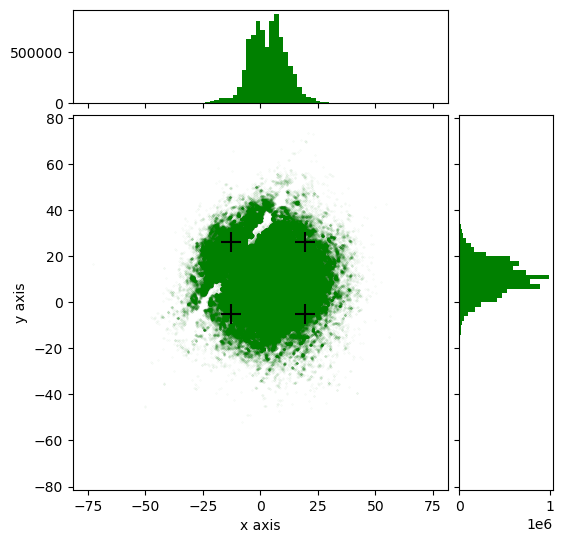

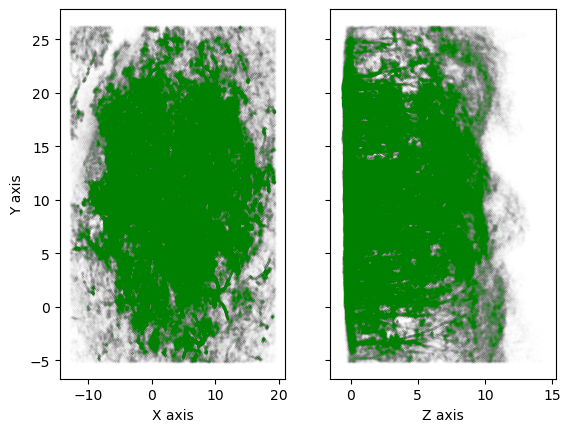

在ROI中的點: 90.87 百分之
第 1 片，現在剩初始的 5.01 百分之
第 2 片，現在剩初始的 4.73 百分之
第 3 片，現在剩初始的 5.06 百分之
第 4 片，現在剩初始的 5.27 百分之
第 5 片，現在剩初始的 5.75 百分之
第 6 片，現在剩初始的 5.57 百分之
第 7 片，現在剩初始的 5.63 百分之
第 8 片，現在剩初始的 5.01 百分之
第 9 片，現在剩初始的 5.06 百分之
第 10 片，現在剩初始的 4.55 百分之
第 11 片，現在剩初始的 4.84 百分之
第 12 片，現在剩初始的 4.37 百分之
第 13 片，現在剩初始的 4.59 百分之
第 14 片，現在剩初始的 4.31 百分之
第 15 片，現在剩初始的 4.84 百分之
第 16 片，現在剩初始的 5.02 百分之
第 17 片，現在剩初始的 5.24 百分之
第 18 片，現在剩初始的 5.13 百分之
第 19 片，現在剩初始的 4.79 百分之
第 20 片，現在剩初始的 4.68 百分之
第 21 片，現在剩初始的 4.73 百分之
第 22 片，現在剩初始的 5.07 百分之
第 23 片，現在剩初始的 5.03 百分之
第 24 片，現在剩初始的 4.89 百分之
第 25 片，現在剩初始的 4.79 百分之
第 26 片，現在剩初始的 4.45 百分之
第 27 片，現在剩初始的 4.25 百分之
第 28 片，現在剩初始的 4.15 百分之
第 29 片，現在剩初始的 3.98 百分之
第 30 片，現在剩初始的 4.29 百分之
第 31 片，現在剩初始的 4.27 百分之
第 32 片，現在剩初始的 4.25 百分之
第 33 片，現在剩初始的 4.76 百分之
第 34 片，現在剩初始的 4.49 百分之
第 35 片，現在剩初始的 4.27 百分之
第 36 片，現在剩初始的 4.46 百分之
第 37 片，現在剩初始的 4.64 百分之
第 38 片，現在剩初始的 4.61 百分之
第 39 片，現在剩初始的 4.48 百分之
第 40 片，現在剩初始的 4.7 百分之
第 41 片，現在剩初始的 4.7 百分之
第 42 片，現在剩初始的 4.34 百分之
第 43 片，現在剩初始的 4.51 百分之
第 4

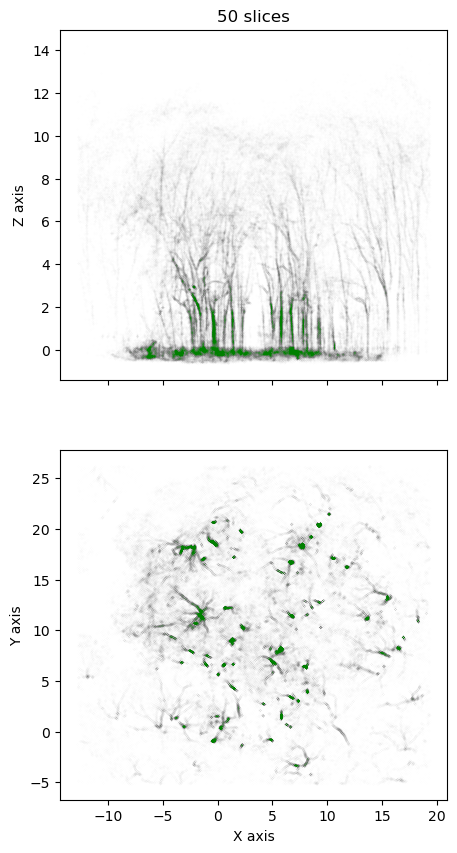

都好了，花了17.41 sec


In [12]:
intensity_filter(original_file,nb_slices,ROI)

### 2 (Cloud Compare): 跟CANUPO的數據過濾

In [77]:
trees_file = 'T3S8.las'

### 3: DBSCAN聚類和3DForest分割的共同註冊，地區生長算法

In [78]:
ROIzmin , ROIzmax = 0.5 , 1.0
eps , min_samples = 0.1 , 10

114 個點簇, 13994 噪聲點 (76.0百分之)


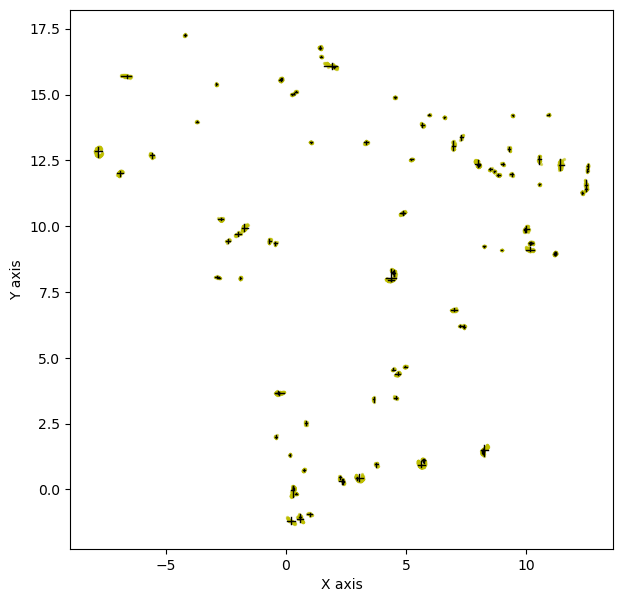

都好了，2.368257761001587 sec


In [79]:
DBSCAN_clustering(trees_file,ROIzmin,ROIzmax,eps,min_samples)

In [80]:
dist_to_merge = 0.3

C:\Users\user2\AppData\Local\Temp\ipykernel_7260\2846032926.py:54: RuntimeWarning: invalid value encountered in less_equal
  Slice = regions[f'{file_name}'][regions[f'{file_name}'][:,2]<=ROIzmax]


融合以後有15 個地區
43


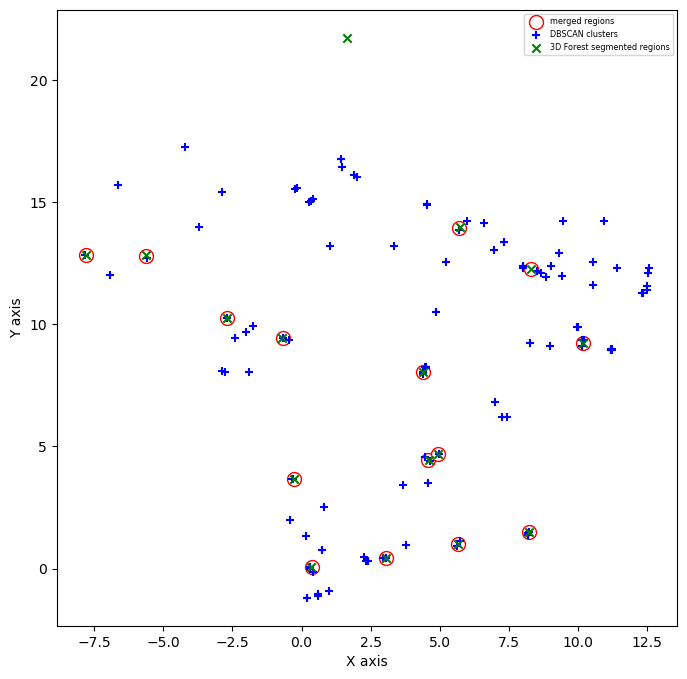

C:\Users\user2\AppData\Local\Temp\ipykernel_7260\2846032926.py:218: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(a,b,i,projection='3d')


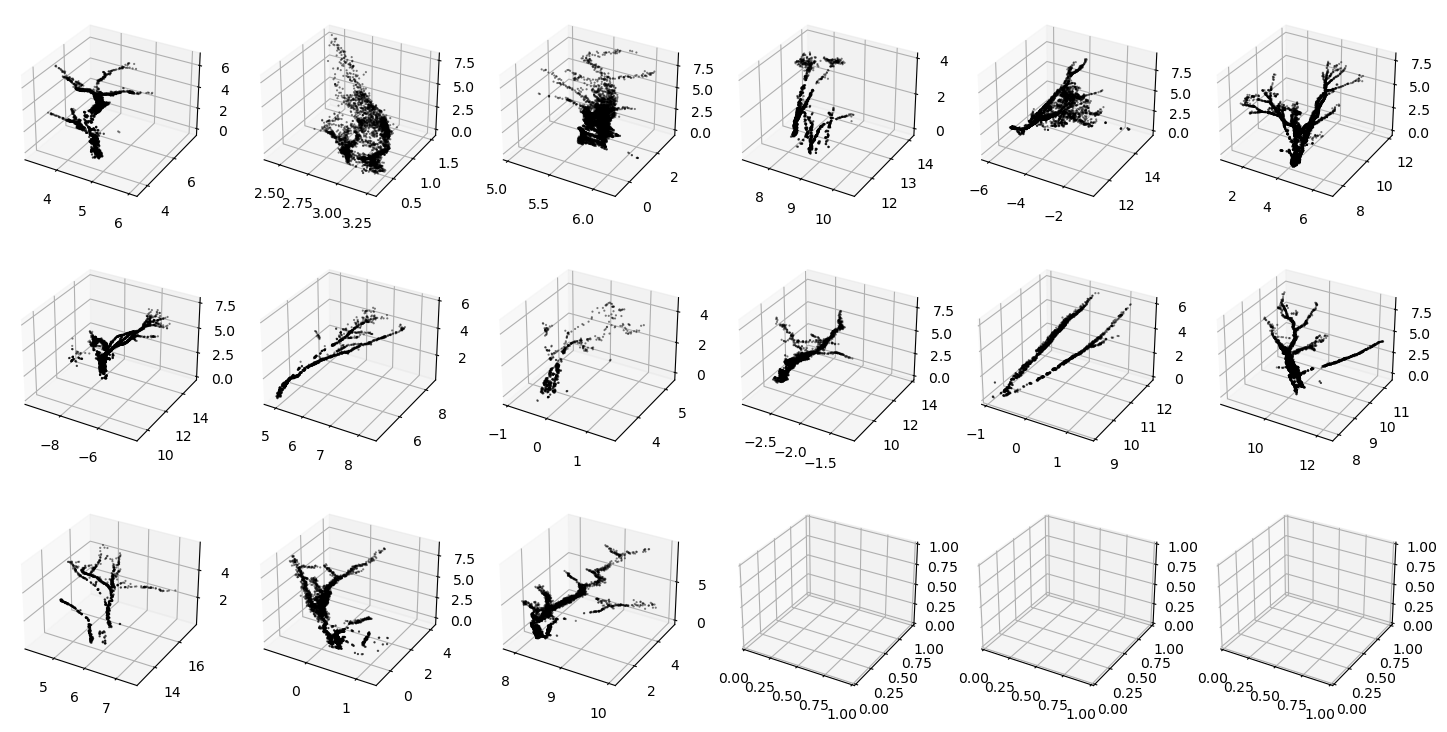

都好了，5.074314117431641 sec


In [81]:
merging(dist_to_merge,ROIzmin,ROIzmax)

In [83]:
dist_to_add_upper = 0.15
dist_to_add_lower = 0.05

加工較高的部分
第 1/15 個地區現在比地區生長以前大得 244.0 百分之
第 2/15 個地區現在比地區生長以前大得 245.0 百分之
第 3/15 個地區現在比地區生長以前大得 235.0 百分之
第 4/15 個地區現在比地區生長以前大得 230.0 百分之
第 5/15 個地區現在比地區生長以前大得 263.0 百分之
第 6/15 個地區現在比地區生長以前大得 227.0 百分之
第 7/15 個地區現在比地區生長以前大得 289.0 百分之
第 8/15 個地區現在比地區生長以前大得 288.0 百分之
第 9/15 個地區現在比地區生長以前大得 267.0 百分之
第 10/15 個地區現在比地區生長以前大得 219.0 百分之
第 11/15 個地區現在比地區生長以前大得 245.0 百分之
第 12/15 個地區現在比地區生長以前大得 224.0 百分之
第 13/15 個地區現在比地區生長以前大得 312.0 百分之
第 14/15 個地區現在比地區生長以前大得 250.0 百分之
第 15/15 個地區現在比地區生長以前大得 231.0 百分之
地區生長以後有 52.165519888464296 百分之噪聲點
加工較低的部分
第 1/15 個地區現在比地區生長以前大得 107.0 百分之
第 2/15 個地區現在比地區生長以前大得 109.0 百分之
第 3/15 個地區現在比地區生長以前大得 106.0 百分之
第 4/15 個地區現在比地區生長以前大得 113.0 百分之
第 5/15 個地區現在比地區生長以前大得 102.0 百分之
第 6/15 個地區現在比地區生長以前大得 105.0 百分之
第 7/15 個地區現在比地區生長以前大得 102.0 百分之
第 8/15 個地區現在比地區生長以前大得 101.0 百分之
第 9/15 個地區現在比地區生長以前大得 118.0 百分之
第 10/15 個地區現在比地區生長以前大得 104.0 百分之
第 11/15 個地區現在比地區生長以前大得 104.0 百分之
第 12/15 個地區現在比地區生長以前大得 107.0 百分之
第 13/15 個地區現在比地區生長以前大得 101.0 百分之
第 14/15 個地區現在比地區生長以前大得 106.0 百分之
第 15/15 個地區

C:\Users\user2\AppData\Local\Temp\ipykernel_7260\1124493881.py:289: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(a,b,i,projection='3d')


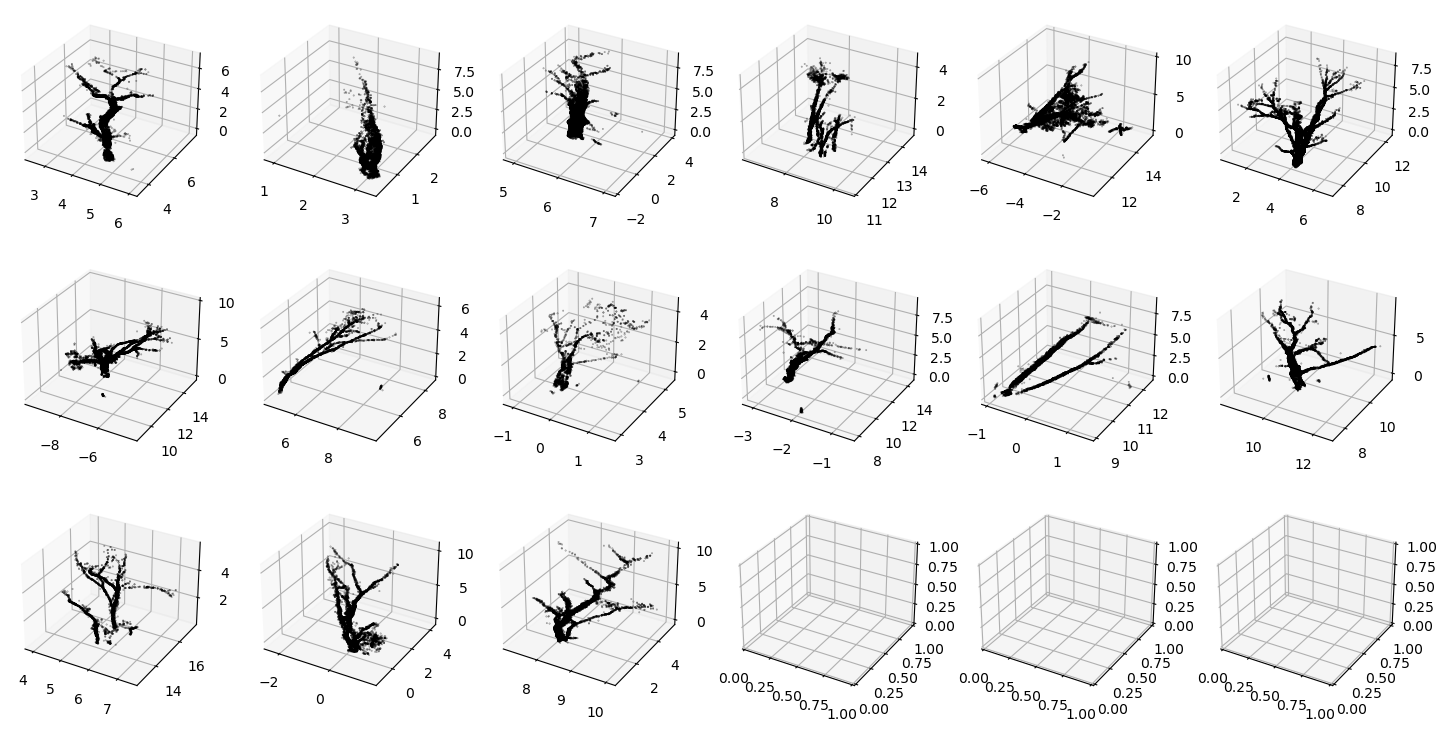

都好了，2519.6694855690002 sec


In [84]:
region_growing(trees_file,dist_to_add_upper,dist_to_add_lower,ROIzmin,ROIzmax)

In [90]:
general_threshold = 0.05
crown_threshold = 0.1
height_for_crown_threshold = 3.5
min_height = 4

+ 13.0 %
1/10: + 9.0 %
2/10: + 23.0 %
3/10: + 49.0 %
4/10: + 36.0 %
5/10: + 32.0 %
6/10: + 46.0 %
7/10: + 32.0 %
8/10: + 36.0 %
9/10: + 111.0 %
10/10: + 49.0 %
較高的部分: + 230.0 %
100.0 % 的樹木足夠高


C:\Users\user2\AppData\Local\Temp\ipykernel_7260\3245439342.py:174: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(a,b,i,projection='3d')


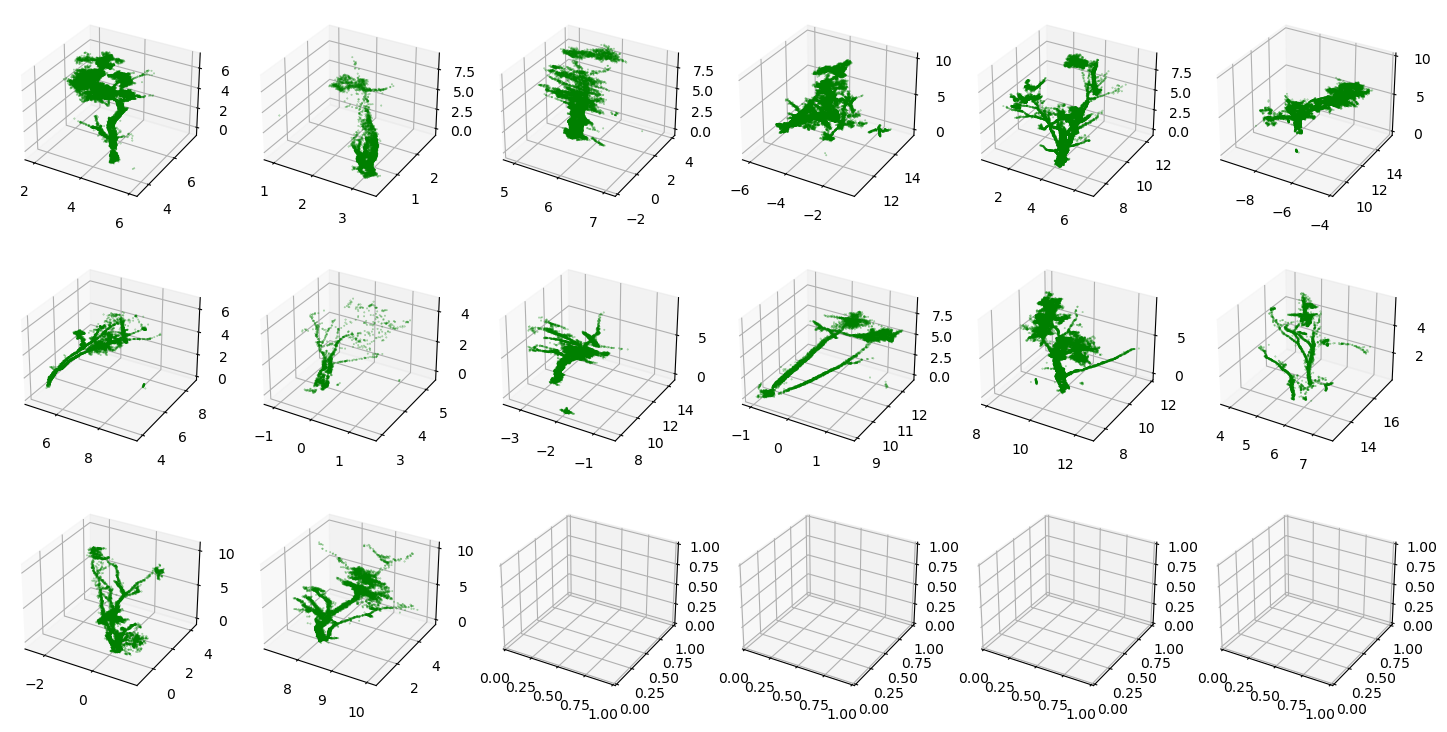

都好了，371.6071012020111 sec


In [91]:
nearest_nbr_reinforcement(original_file, general_threshold, crown_threshold, height_for_crown_threshold,min_height)

### 4: QSM·最終數據

In [92]:
start_location = [121.4951668,23.7890555]

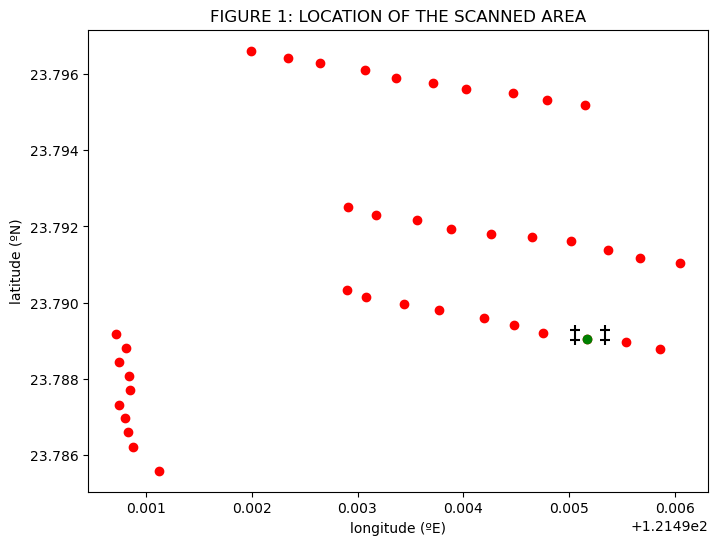

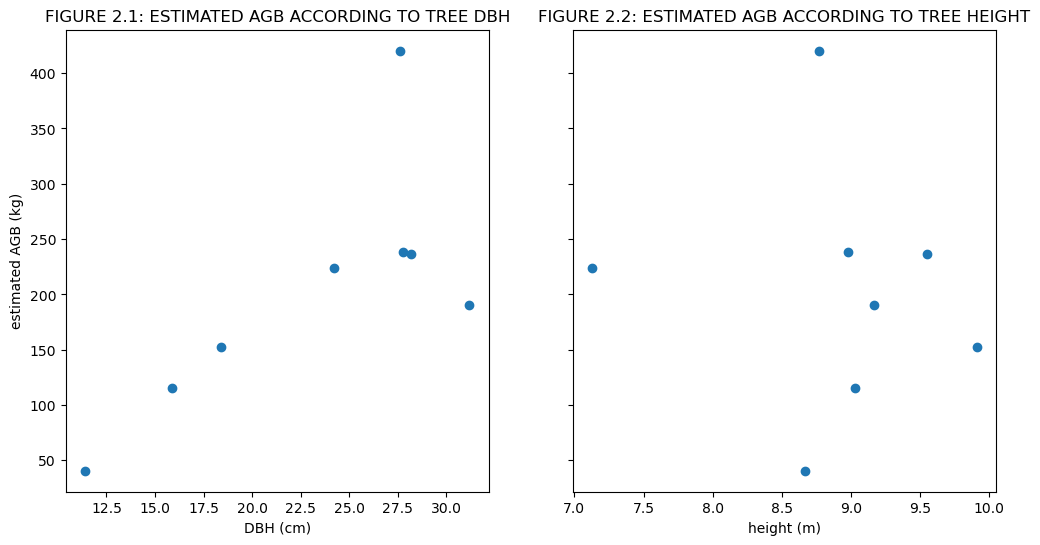

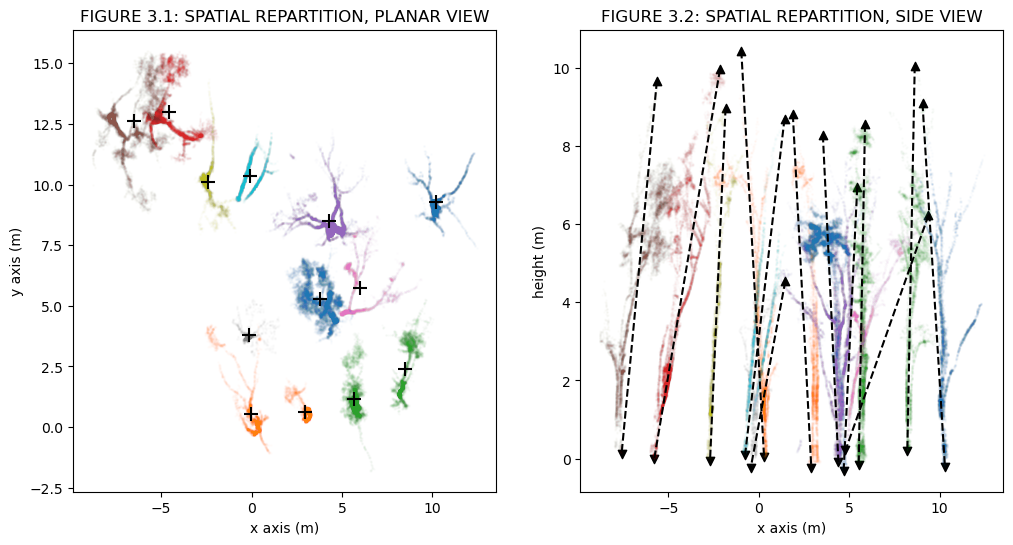

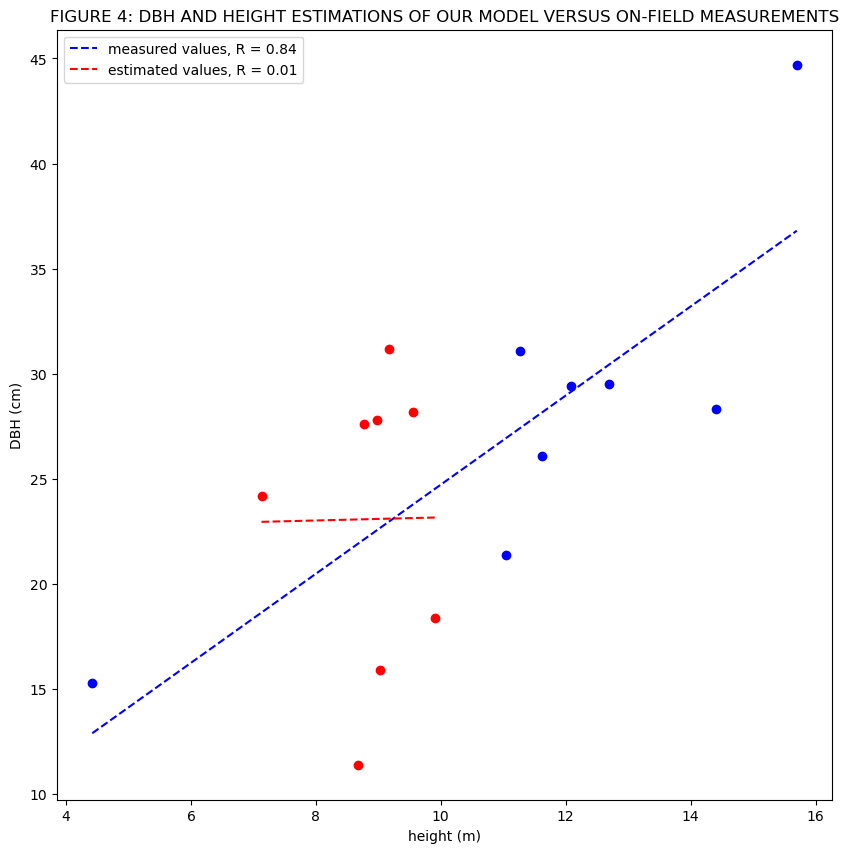

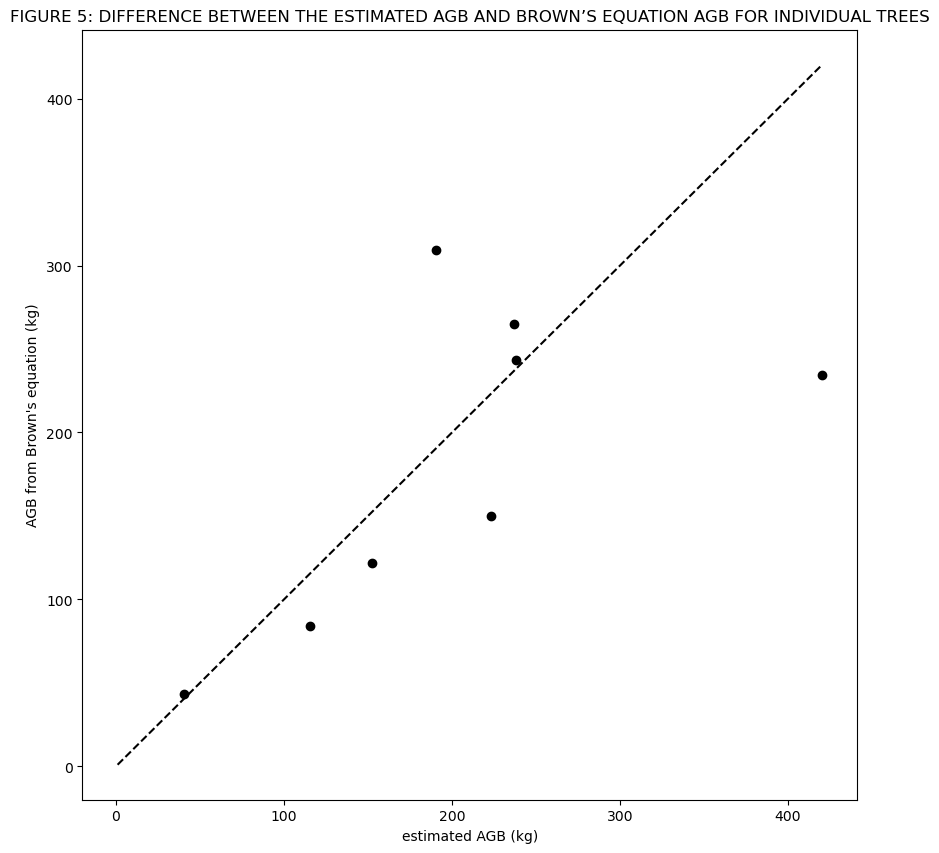

都好了，4.072295188903809 sec


In [94]:
plot_results(start_location)